## Object detection metrics and errors 
Object detection and instance segmentation primarily use one metric to judge performance: `mean Average Precision (mAP )`. How do we interpret it? For a metric like `accuracy` we know that 90% means that the model is wrong `10%` of the time. we will see the following things in this blog.
- what does a mAP of `63.2%` actually mean? 
- why do we use `mAP` as a metric in object detection? 
- what kind of errors are associated with your model which is hampering your overall score?
    - A `false positive` can be a 
        - duplicate detection
        - misclassification
        - mislocalization
        - confusion with background
        - both a misclassification and mislocalization.
    - a false negative could be a 
        - completely missed ground truth, 
        - potentially correct prediction could have just been misclassified or mislocalized. 

There are 3 places our detector can affect mAP 
- outputting false positives during the matching step, 
- not outputting true positives (i.e., false negatives) for computing recall, 
- having incorrect calibration (i.e., outputting a higher confidence for a false positive then a true positive).

The difficulty of the code has increased because
- we have multiple classes 
- we have multiple thresholds 
- we have to do for both mask and bbox
- we have multiple metrics [small, medium, large, mAR, mAP]


we will simplify the code by 
- using one single threshold (mAP 50)
- only bbox 
- only mAP 

First lets calculate `mAP` of the model. we will First use `torchvision` retinanet on COCO dataset

In [34]:
import numpy as np 
import pandas as pd
import torchvision
import torch
from PIL import Image
from pathlib import Path
import pandas as pd
from pycocotools.coco import COCO
from torchvision.ops.boxes import _box_xywh_to_xyxy as xywh_to_xyxy
from typing import Union
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline 

plt.style.use("bmh")

> Load the model.

In [2]:
weights = torchvision.models.detection.retinanet.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights = weights, num_classes=91)
model.eval()
preprocess= weights.DEFAULT.transforms()

> Load the data

In [3]:
class COCODataset:
    def __init__(self, img_root, annot_loc, transforms=None):
        self.coco = COCO(annot_loc)
        self.img_root = Path(img_root)
        self.img_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_meta = self.coco.imgs[img_id]
        img_loc = self.img_root / img_meta["file_name"]
        img = Image.open(img_loc)
        
        ## Load annotations 
        annot_ids = self.coco.getAnnIds(imgIds=[img_id])
        annots = self.coco.loadAnns(ids = annot_ids)
        
        if self.transforms is not None:
            return self.transforms(img).unsqueeze(0), annots
        return img, annots
    
    def __len__(self):
        return len(self.coco.imgs) 

In [4]:
annot_loc = "data/coco/annotations/instances_val2017.json"
img_root = "data/coco/val2017/"
ds = COCODataset(img_root, annot_loc=annot_loc, transforms=preprocess)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


> Load a single image with its annotations.

In [5]:
img, annots = ds[10]

> Generate predictions

- This model uses an nms threshold of 0.5. check `model.nms_thresh`
- The output is a dict with boxes, scores, labels as keys. 

In [6]:
with torch.no_grad():
    output = model(img)
output[0].keys()

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


dict_keys(['boxes', 'scores', 'labels'])

## check FP's, FN's and TP's for each bbox.
Each bbox (both gt and pred), we need to assign TP, FP or FN label. We will do this at 3 levels
- single image single class `SISCE` 
- single image all classes `SIE`
- Dataset level `DE`
where `E` stands for Error. 

### SISCE: single image, single class error
- this works on single image and for a single class.
- It calculates IOU between gt and pred of the same class bboxes. 
- For gt, it assigns TP or FN label
- For preds, it assigns TP or FP label.
- creats gt and preds df with scores.

In [7]:
pred_boxes = output[0]["boxes"]
pred_scores = output[0]["scores"]
pred_labels = output[0]["labels"]
print(pred_boxes.shape, pred_scores.shape, pred_labels.shape)

torch.Size([182, 4]) torch.Size([182]) torch.Size([182])


In [8]:
gt_boxes = torch.Tensor([i["bbox"] for i in annots])
gt_boxes = xywh_to_xyxy(gt_boxes)
gt_labels = torch.Tensor([i["category_id"] for i in annots])
print(gt_labels.shape, gt_boxes.shape)

torch.Size([26]) torch.Size([26, 4])


for each predicted bounding box we need to see if it has a correct match or not. we will do this for each class in each image first. 

In [9]:
categories = list(ds.coco.cats.keys())
req_cat = categories[0]
req_gt_boxes = gt_boxes[gt_labels ==1]
req_pred_boxes = pred_boxes[pred_labels == 1]
req_pred_scores = pred_scores[pred_labels==1]
print(req_cat, req_pred_boxes.shape, req_pred_scores.shape, req_gt_boxes.shape)

1 torch.Size([57, 4]) torch.Size([57]) torch.Size([13, 4])


In [10]:
class SISCE:
    #SingleImage_SingleClassError
    #
    def __init__(self, iou_thr):
        self.iou_thr = iou_thr
    
    def find_all_matches(self, c1: Union[torch.Tensor, np.asarray], c2:Union[torch.Tensor, np.asarray]):
        all_matches = np.empty((0, 3))
        if (len(c1) == 0) or (len(c2) == 0):
            return all_matches
        iou = torchvision.ops.box_iou(c1, c2).numpy()
        want_idx = np.where(iou > self.iou_thr)
        all_matches = []
        for i in range(want_idx[0].shape[0]):
            all_matches.append(
                [
                    want_idx[0][i],
                    want_idx[1][i],
                    iou[want_idx[0][i], want_idx[1][i]],
                ]
            )
        ## [N, 3]: i, j, score. [gt_index, pred_index, iou_score]
        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]
            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]
            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]
        return all_matches 
    
    def find_gt_metrics(self, c1: Union[torch.Tensor, np.asarray], all_matches: np.asarray):
        # wheather a gt bbox is TP(matcheed with a predication) or FN(was not recognized by the alogrithm)
        c1_tt = []
        for num, gt_ctscanannot in enumerate(c1):
            TP_FP_FN = "FN"
            if len(all_matches) > 0:
                if num in all_matches[:, 0].tolist():
                    TP_FP_FN = "TP"
            c1_tt.append(TP_FP_FN)
        assert len(c1) == len(c1_tt), "there is a mismatch between number of nodules and labels"
        return c1_tt
    
    def get_gt_pd(self, c1: Union[torch.Tensor, np.asarray], all_matches: np.asarray):
        c1_tt = self.find_gt_metrics(c1, all_matches)
        return self.to_df(c1, c1_tt)
    
    def to_df(self, c1, c1_tt):
        if isinstance(c1, torch.Tensor):
            c1 = c1.numpy()
        df = pd.DataFrame(c1)
        df.columns = ["x1", "y1", "x2", "y2"]
        df["TP_FP_FN"] = c1_tt
        return df 
    
    
    def get_pred_pd(self, c1: Union[torch.Tensor, np.asarray], scores: Union[torch.Tensor, np.asarray], all_matches: np.asarray):
        c2_tt = self.find_pred_metrics(c1, all_matches)
        df = self.to_df(c1, [i[0] for i in c2_tt])
        df["iou_score"] = [i[1] for i in c2_tt]
        if isinstance(scores, torch.Tensor):
            scores = scores.numpy()
        df["cnf_score"] = scores
        return df 
        
    
    def find_pred_metrics(self, c1: Union[torch.Tensor, np.asarray], all_matches: np.asarray):
        c2_tt = []
        for num, pred_ctscaannot in enumerate(c1):
            iou_score, TP_FP_FN = 0.0, "FP"
            iou_score = 0.0
            if len(all_matches) > 0:
                if num in np.int64(all_matches[:, 1]):
                    index = int(np.where(np.int64(all_matches[:, 1]) == num)[0])
                    iou_score = all_matches[index][2]
                    TP_FP_FN = "TP"
            c2_tt.append([TP_FP_FN, iou_score])
        assert len(c1) == len(c2_tt), "there is a mismatch between number of nodules and labels"
        return c2_tt
    
    def forward(self, gt, pred, scores):
        matches = self.find_all_matches(gt, pred)
        preds_df = self.get_pred_pd(pred, scores, matches)
        gt_df = self.get_gt_pd(gt, matches)
        return gt_df, preds_df 

In [11]:
error = SISCE(0.5)

In [12]:
all_matches = error.find_all_matches(req_gt_boxes, req_pred_boxes)
all_matches

array([[ 0.        ,  1.        ,  0.76189595],
       [ 1.        ,  4.        ,  0.84801769],
       [ 2.        ,  0.        ,  0.92562395],
       [ 3.        ,  2.        ,  0.88024729],
       [ 4.        ,  8.        ,  0.63157892],
       [ 5.        ,  6.        ,  0.88249034],
       [ 6.        , 10.        ,  0.8462857 ],
       [ 7.        , 11.        ,  0.87101638],
       [ 8.        , 13.        ,  0.77039939],
       [ 9.        , 17.        ,  0.84931129],
       [10.        ,  7.        ,  0.89238977],
       [11.        ,  3.        ,  0.85208613],
       [12.        ,  5.        ,  0.65539688]])

In [13]:
pred_df_sisc  = error.get_pred_pd(req_pred_boxes, req_pred_scores, all_matches)
print(pred_df_sisc.shape)
pred_df_sisc.head()

(57, 7)


,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score
0,0.210682,265.643738,110.534225,422.256592,TP,0.925624,0.875509
1,313.360962,284.719269,392.871094,421.843689,TP,0.761896,0.829786
2,429.111725,274.314087,533.618408,404.633026,TP,0.880247,0.819460
3,494.161133,276.724335,586.270264,385.799164,TP,0.852086,0.804641
4,273.743530,291.526611,330.614044,415.199249,TP,0.848018,0.783450


In [14]:
gt_df_sisc = error.get_gt_pd(req_gt_boxes, all_matches)
print(gt_df_sisc.shape)
gt_df_sisc.head()

(13, 5)


,x1,y1,x2,y2,TP_FP_FN
0,322.570007,290.809998,387.660004,418.429993,TP
1,273.640015,292.109985,324.590027,421.759979,TP
2,1.920000,266.880005,116.369995,422.669983,TP
3,424.119995,270.589996,531.589966,400.130005,TP
4,259.269989,281.000000,285.289978,316.100006,TP


### SIE: single image error 
- this basically evaluates at image level across all the classes.
- in case if you want to limit to single class we can use the earlier function or set the class label here. 

In [15]:
class SIE:
    # Single image error
    def __init__(self, iou_thr):
        self.sisce = SISCE(iou_thr=iou_thr)
    
    def forward_class(self, 
                      gts: torch.Tensor, 
                      gt_labels: torch.Tensor, 
                      preds: torch.Tensor, 
                      pred_scores: torch.Tensor, 
                      pred_labels: torch.Tensor, 
                      req_label: int):
        req_gt_boxes = gts[gt_labels ==req_label]
        req_pred_boxes = preds[pred_labels == req_label]
        req_pred_scores = pred_scores[pred_labels == req_label]
        gt_df, pred_df = self.sisce.forward(req_gt_boxes, req_pred_boxes, req_pred_scores)
        gt_df["label"] = gt_labels[gt_labels == req_label].numpy()
        pred_df["label"] = pred_labels[pred_labels==req_label]
        return gt_df, pred_df 
    
    def forward(self, 
                gt: torch.Tensor, 
                gt_labels: torch.Tensor, 
                pred: torch.Tensor, 
                pred_score: torch.Tensor, 
                pred_labels: torch.Tensor,):
        gts_df, preds_df = [], []
        labels = torch.hstack([pred_labels, gt_labels]).unique()
        for label in labels.unique():
            gt_df, pred_df = self.forward_class(gt, gt_labels, pred, pred_score, pred_labels, req_label= label)
            gts_df.append(gt_df)
            preds_df.append(pred_df)            
        return pd.concat(gts_df).reset_index(drop=True), pd.concat(preds_df).reset_index(drop=True)    

In [16]:
img_error = SIE(iou_thr=0.5)

In [17]:
gts_df, preds_df = img_error.forward(gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)
print(gts_df.shape, preds_df.shape)

(26, 6) (182, 8)


In [18]:
gts_df.head()

,x1,y1,x2,y2,TP_FP_FN,label
0,322.570007,290.809998,387.660004,418.429993,TP,1.0
1,273.640015,292.109985,324.590027,421.759979,TP,1.0
2,1.920000,266.880005,116.369995,422.669983,TP,1.0
3,424.119995,270.589996,531.589966,400.130005,TP,1.0
4,259.269989,281.000000,285.289978,316.100006,TP,1.0


In [19]:
preds_df.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label
0,0.210682,265.643738,110.534225,422.256592,TP,0.925624,0.875509,1
1,313.360962,284.719269,392.871094,421.843689,TP,0.761896,0.829786,1
2,429.111725,274.314087,533.618408,404.633026,TP,0.880247,0.819460,1
3,494.161133,276.724335,586.270264,385.799164,TP,0.852086,0.804641,1
4,273.743530,291.526611,330.614044,415.199249,TP,0.848018,0.783450,1


## Lets do this at Dataset level

In [20]:
ds

In [21]:
gts_df, preds_df = [], []
for d in tqdm(range(len(ds))):
    img, annots = ds[d]
    
    with torch.no_grad():
        output = model(img)
        
    ## Ground truths
    gt_boxes = torch.Tensor([i["bbox"] for i in annots])
    gt_boxes = xywh_to_xyxy(gt_boxes)
    gt_labels = torch.Tensor([i["category_id"] for i in annots])
    
    ## preds 
    pred_boxes = output[0]["boxes"]
    pred_scores = output[0]["scores"]
    pred_labels = output[0]["labels"]
    
    tt = SIE(0.5)
    gt_df, pred_df = img_error.forward(gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)
    gts_df.append(gt_df)
    preds_df.append(pred_df)
    
gts_df = pd.concat(gts_df).reset_index(drop=True)
preds_df = pd.concat(preds_df).reset_index(drop=True)

  0%|                                                                                        | 5/5000 [01:22<22:55:37, 16.52s/it]


## calculate metrics 
since we have identified TP, FP or FN for each bbox in gt and pred. now lets calculate AP for each class and then mAP of the entire dataset. 

In [26]:
tt = preds_df.sort_values("cnf_score", ascending=False)
pred_sc = tt[tt["label"] == 1].reset_index(drop=True)
gt_sc = gts_df[gts_df["label"] == 1].reset_index(drop=True)
print(gt_sc.shape, pred_sc.shape)

(19, 6) (153, 8)


In [27]:
pred_sc["TP"] = pred_sc["TP_FP_FN"].apply(lambda x: 1 if x == "TP" else 0)
pred_sc["FP"] = pred_sc["TP_FP_FN"].apply(lambda x: 1 if x == "FP" else 0)

pred_sc["acc_tp"] = pred_sc["TP"].cumsum()
pred_sc["acc_fp"] = pred_sc["FP"].cumsum()
pred_sc.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label,TP,FP,acc_tp,acc_fp
0,344.064667,166.239029,421.646393,356.626617,TP,0.895064,0.948951,1,1,0,1,0
1,326.498016,172.822937,396.342224,370.975037,TP,0.967901,0.929150,1,1,0,2,0
2,508.890900,169.926651,631.921448,385.082062,TP,0.955729,0.920736,1,1,0,3,0
3,9.601577,167.568085,132.564224,394.536621,TP,0.985011,0.915256,1,1,0,4,0
4,256.173676,223.436707,302.513489,316.329956,TP,0.894396,0.875832,1,1,0,5,0


In [28]:
## This is box detection precision.
pred_sc["precision"] = pred_sc["acc_tp"] / (pred_sc["acc_tp"] + pred_sc["acc_fp"] + 1e-16)
pred_sc["recall"] = pred_sc["acc_tp"] / (gt_sc.shape[0] + 1e-16)
pred_sc["AvgFalsePosScan"] = pred_sc["acc_fp"] / (gt_sc.shape[0] + 1e-16)
pred_sc.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label,TP,FP,acc_tp,acc_fp,precision,recall,AvgFalsePosScan
0,344.064667,166.239029,421.646393,356.626617,TP,0.895064,0.948951,1,1,0,1,0,1.0,0.052632,0.0
1,326.498016,172.822937,396.342224,370.975037,TP,0.967901,0.929150,1,1,0,2,0,1.0,0.105263,0.0
2,508.890900,169.926651,631.921448,385.082062,TP,0.955729,0.920736,1,1,0,3,0,1.0,0.157895,0.0
3,9.601577,167.568085,132.564224,394.536621,TP,0.985011,0.915256,1,1,0,4,0,1.0,0.210526,0.0
4,256.173676,223.436707,302.513489,316.329956,TP,0.894396,0.875832,1,1,0,5,0,1.0,0.263158,0.0


In [30]:
def compute_ap(recall, precision):
    """Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [recall[-1] + 0.01]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

In [31]:
ap, mpre, mrec = compute_ap(pred_sc["recall"].values, pred_sc["precision"].values)

In [32]:
ap

0.744329928970971

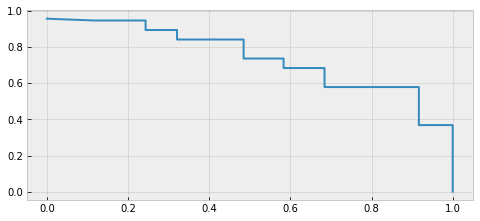

In [36]:
fig, ax = plt.subplots(figsize=(8, 3.5), nrows=1, ncols=1)
ax.plot(mpre, mrec)
plt.show()